In [1]:
import numpy as np
import os
import random
from copy import deepcopy
import torchvision, cv2
from skimage import filters, morphology, restoration, transform
import matplotlib as plt
from pathlib import Path
from utils.plots import plot_confusion_matrix
import utils.dataset as ds
from utils.transforms import *
from utils.plots import *
from utils.experiment import Experiment
from utils.logging_utils import f1_scores_from_conf_mat

In [2]:
import utils.dataset as ds
import torchvision, cv2
import importlib

importlib.reload(ds)

physionet = ds.PhysionetDataset(train=True)
slp = ds.SLPDataset(train=True)
ambienta = ds.AmbientaDataset(train=True)
cifar = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)

Files already downloaded and verified


In [10]:
indices_per_class_physionet = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class_physionet[i] = np.where(physionet.y == i)[0]

indices_per_class_slp = {}
for i, label in enumerate(ds.PostureClass):
    indices_per_class_slp[i] = np.where(slp.y == i)[0]

physionet_samples = [
    sample
    for sample in map(
        lambda c: physionet[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class_physionet.values()) * 5,
    )
    if sample is not None
]

slp_samples = [
    sample
    for sample in map(
        lambda c: slp[random.choice(c)] if len(c) > 0 else None,
        list(indices_per_class_slp.values()) * 5,
    )
    if sample is not None
]

samples = physionet_samples * 2
samples[5::10] = slp_samples[::5]
samples[6::10] = slp_samples[1::5]
samples[7::10] = slp_samples[2::5]
samples[8::10] = slp_samples[3::5]
samples[9::10] = slp_samples[4::5]

[(array([[0., 0., 0., ..., 2., 0., 0.],
       [1., 3., 0., ..., 1., 0., 0.],
       [1., 3., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32), 0), (array([[0., 0., 0., ..., 2., 0., 0.],
       [1., 2., 0., ..., 1., 0., 0.],
       [1., 3., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32), 0), (array([[0., 1., 0., ..., 3., 0., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 0), (array([[0., 0., 0., ..., 3., 0., 0.],
       [1., 2., 1., ..., 0., 0., 0.],
       [0., 2., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0.

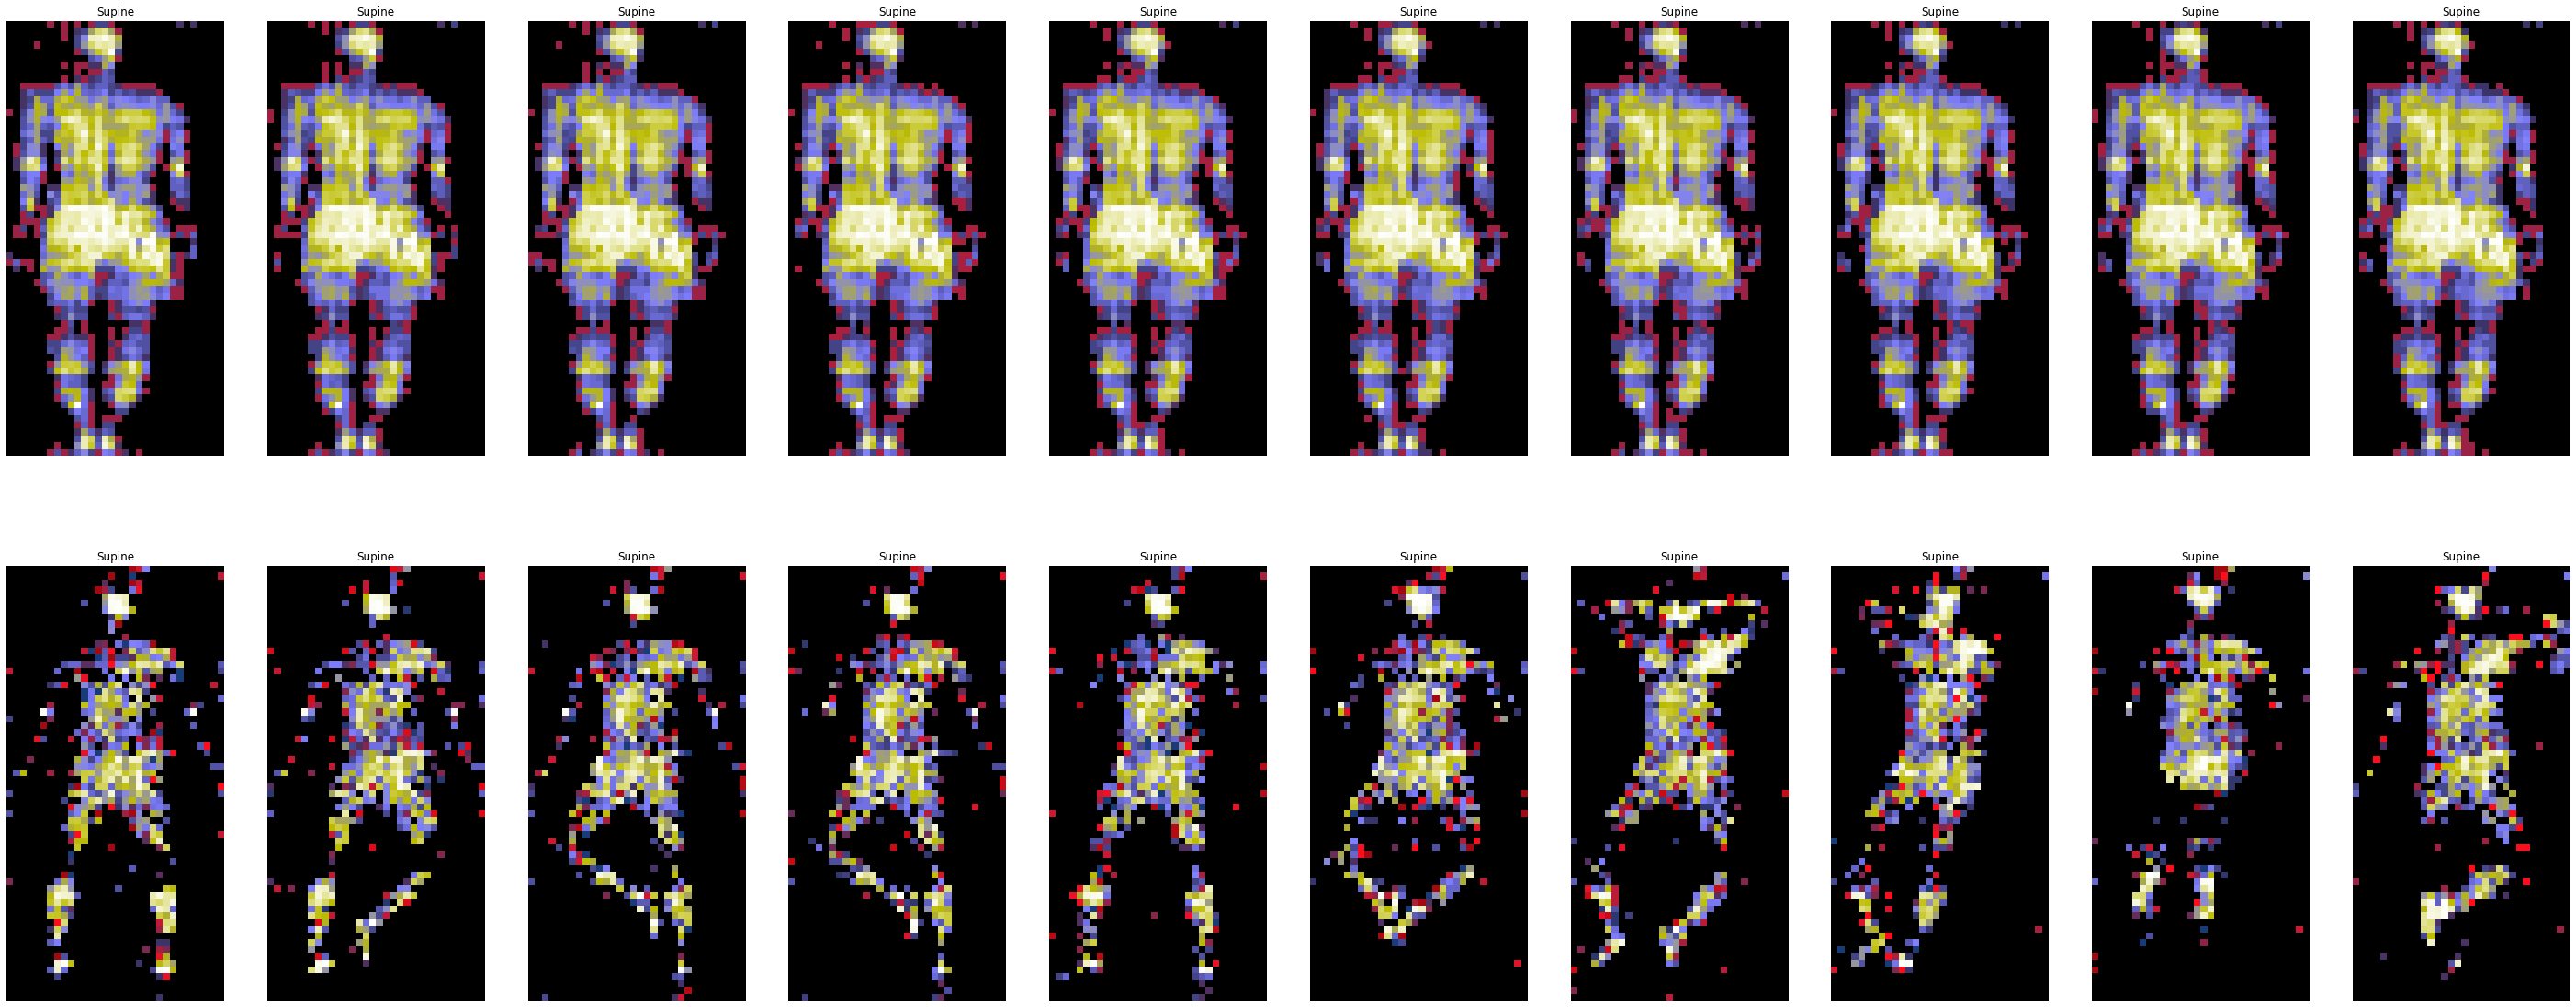

In [15]:
normalizations = [
    Resize((32, 64)),
    Standardize(),
    NormalizeMinMax(),
    EqualizeHist(),
]

notrandom = [physionet[x] for x in range(10)] + [slp[x] for x in range(10)]

plot_samples(
    notrandom,
    ncols=10,
    transform=torchvision.transforms.Compose(
        normalizations
    ),
)

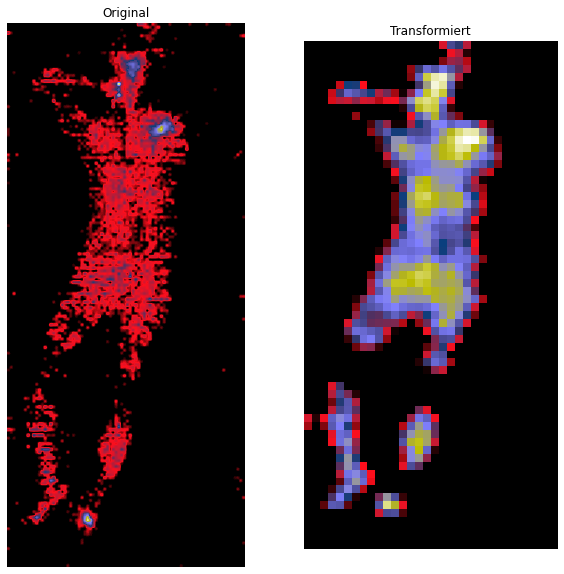

In [15]:
t = torchvision.transforms.Compose(
    [
        # Resize((32, 64)),
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Blur((3, 3)),
        Denoise(),
        Threshold(lambda img: np.median(img[img > 0.0])),
        Close((3, 3), ktype=cv2.MORPH_CROSS, iterations=3),
        # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=3),
        Blur((3, 3)),
        Resize((32, 64)),
        # Threshold(lambda img: np.median(img)),
        # Close((2, 4), ktype=cv2.MORPH_CROSS, iterations=2),
        # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
        # Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
    ]
)

images = [slp[7][0], t(slp[7][0])]

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
for i, (col, image) in enumerate(zip(axs, images)):
    plot_image(image, title="Original" if i == 0 else "Transformiert", ax=col)

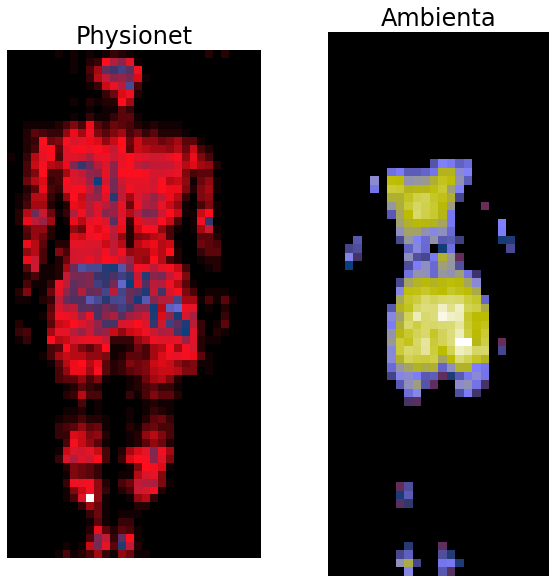

In [14]:
images = [physionet[7][0], ambienta[70][0]]

image_row(*images, titles=["Physionet", "Ambienta"])

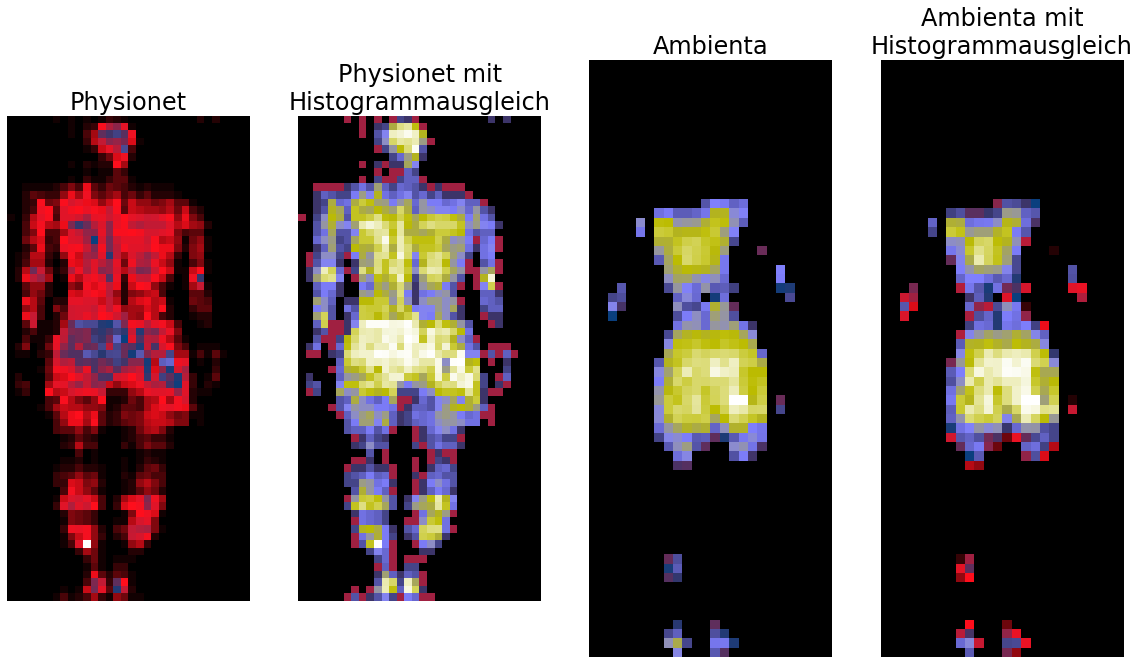

In [10]:
t = torchvision.transforms.Compose(
    [
        NormalizeMinMax(),
        EqualizeHist(),
    ]
)

images = [physionet[7][0], t(physionet[7][0]), ambienta[70][0], t(ambienta[70][0])]

image_row(*images, titles=["Physionet", "Physionet mit\nHistogrammausgleich", "Ambienta", "Ambienta mit\nHistogrammausgleich"], figsize=(20, 50))

<AxesSubplot:>

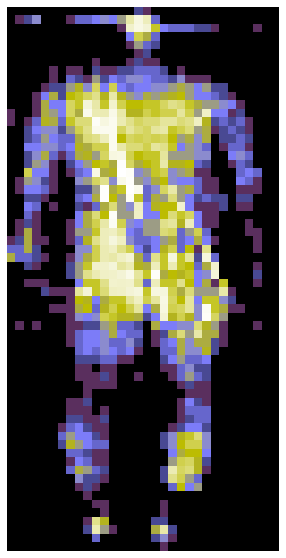

In [6]:
t = torchvision.transforms.Compose(
    [
        NormalizeMinMax(),
        EqualizeHist(),
    ]
)

image = t(physionet[10488][0])

plot_image(image, title=None)

# Morphologische Operationen

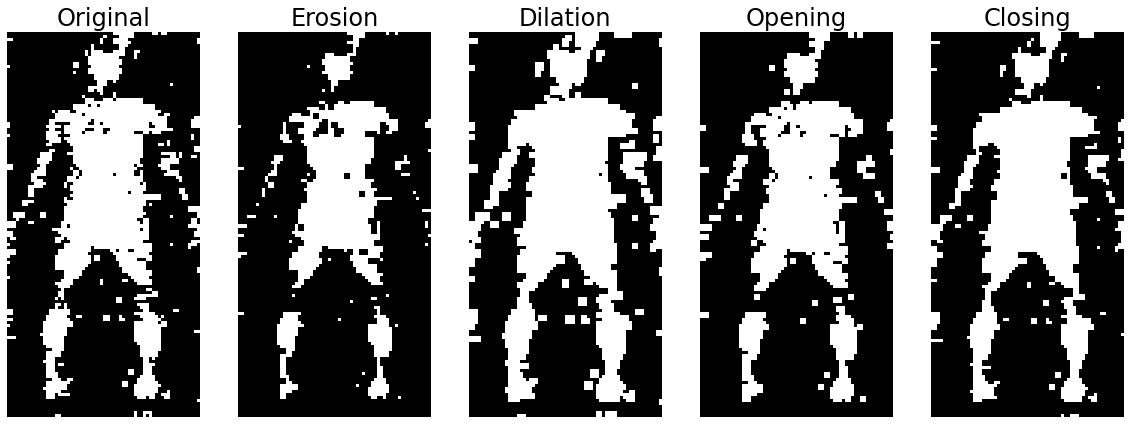

In [3]:
t = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
    ]
)
tt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
        Erode((2, 2)),
    ]
)
ttt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
        Dilate((2, 2)),
    ]
)
tttt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
        Open((2, 2)),
    ]
)
ttttt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        Threshold(lambda img: 0.0, type=cv2.THRESH_BINARY),
        Close((2, 2)),
    ]
)
image = slp[0][0]

images = [t(image), tt(image), ttt(image), tttt(image), ttttt(image)]

image_row(*images, titles=["Original", "Erosion", "Dilation", "Opening", "Closing"], figsize=(20, 10))

# Hoch- und Tiefpassfilter

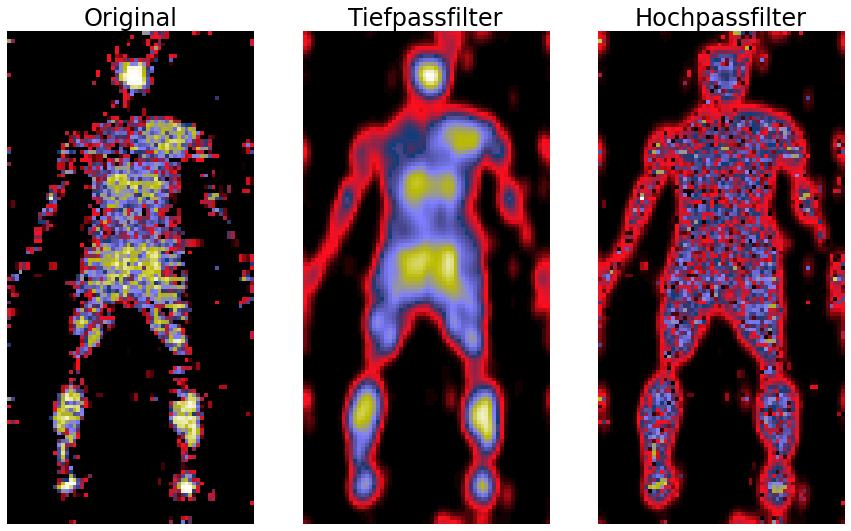

In [12]:
t = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
    ]
)
tt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        LowPass(rad=60),
    ]
)
ttt = torchvision.transforms.Compose(
    [
        Standardize(),
        NormalizeMinMax(),
        EqualizeHist(),
        Resize((64, 128)),
        HighPass(rad=60),
    ]
)
image = slp[0][0]
images = [t(image), tt(image), ttt(image)]

image_row(*images, titles=["Original", "Tiefpassfilter", "Hochpassfilter", "Opening", "Closing"], figsize=(15, 10))

[0.8842606824469721, 0.9608626198083068, 0.8726065866734748]
0.9059099629762511


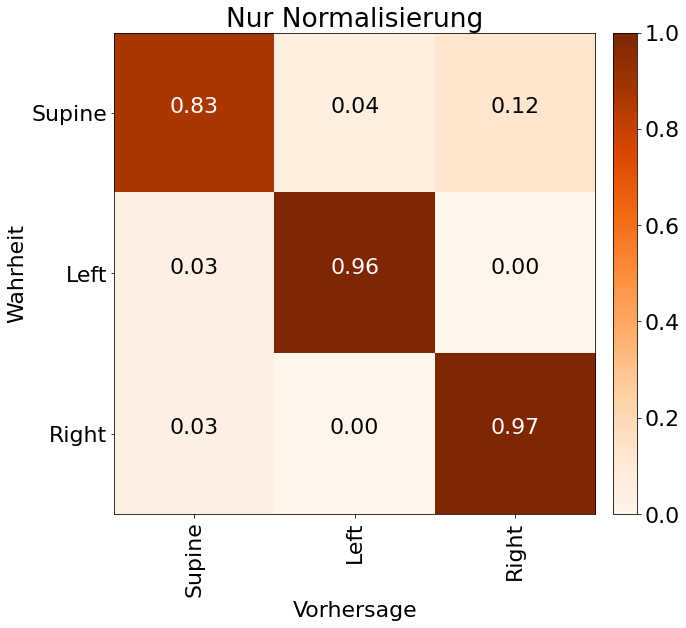

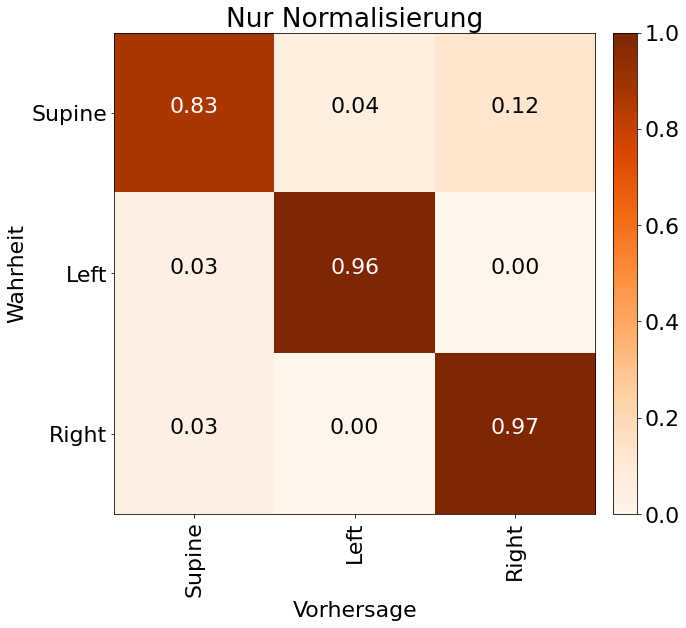

In [6]:
path = Path("runs").joinpath("2022-06-05_10-21-11_Random Rotate").joinpath("confmat.npy")
conf_mat = np.load(str(path))
print(f1_scores_from_conf_mat(conf_mat))
print(sum(f1_scores_from_conf_mat(conf_mat))/3)
plot_confusion_matrix(conf_mat, title="Nur Normalisierung", normalize=True)

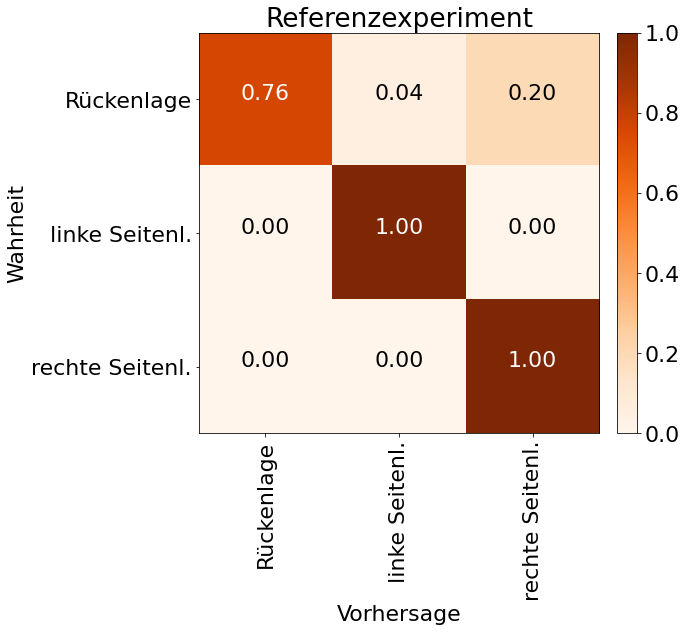

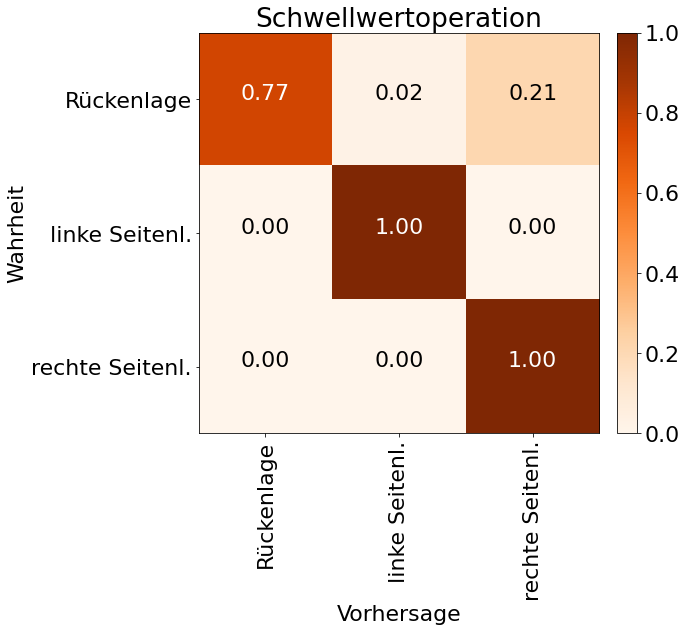

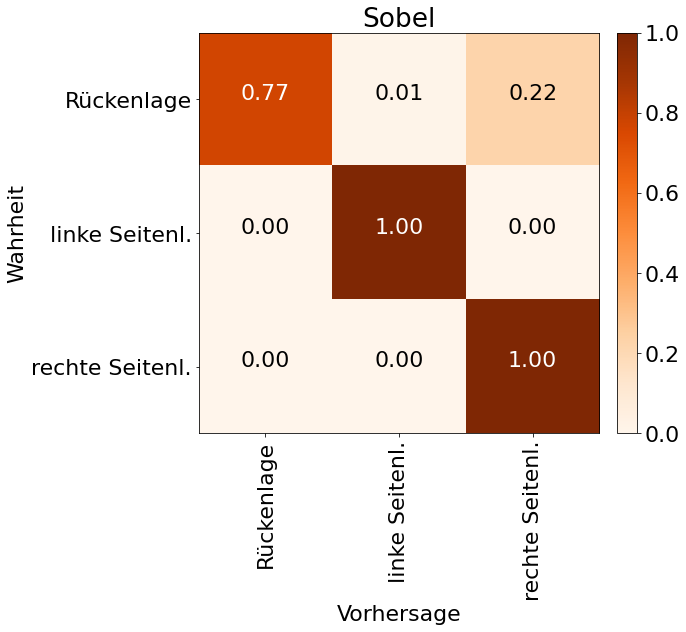

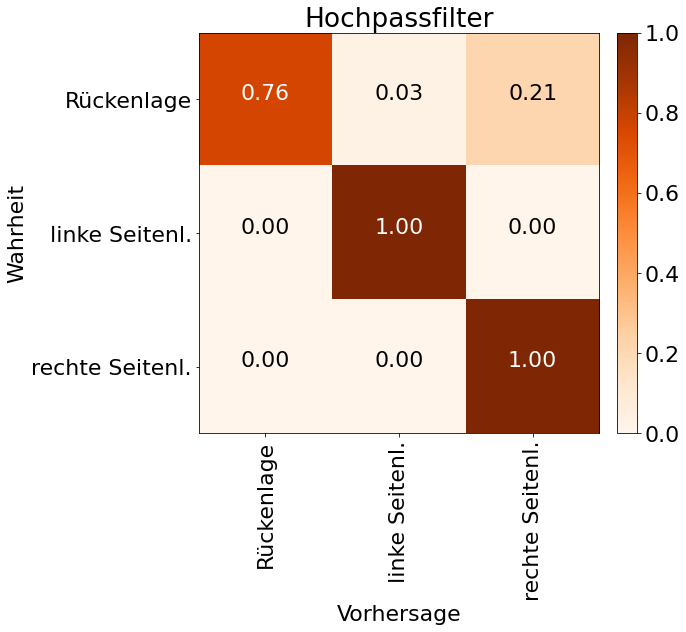

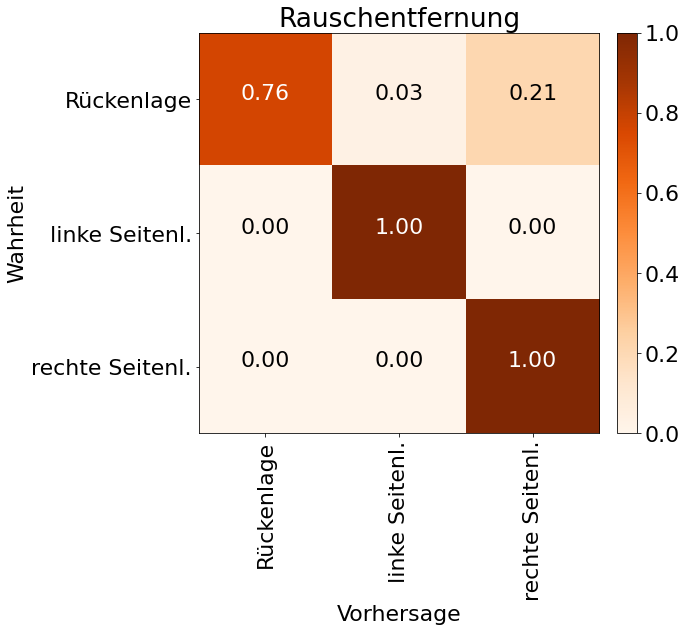

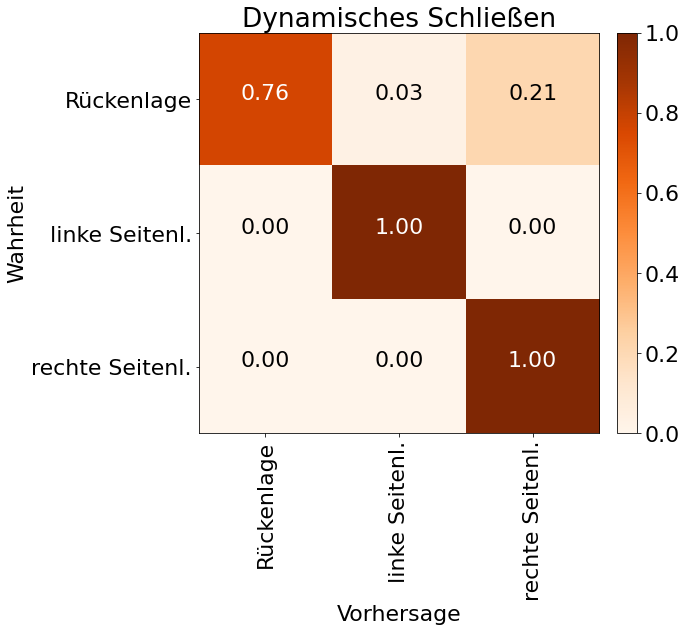

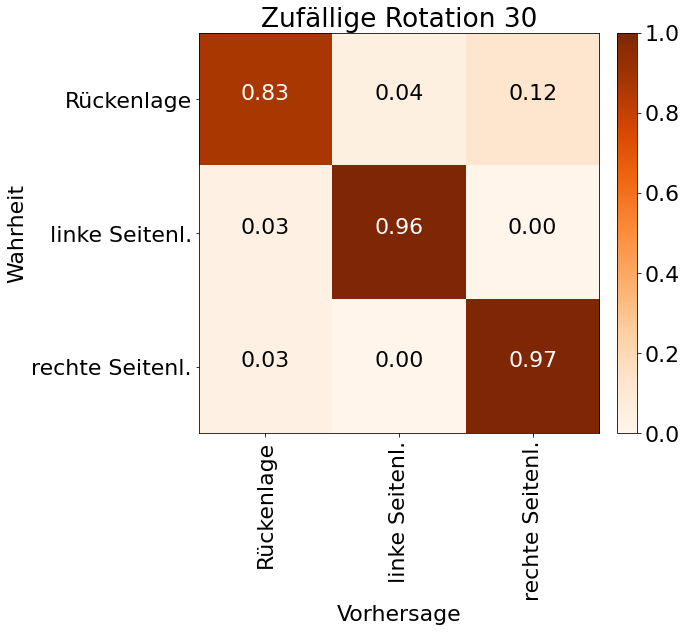

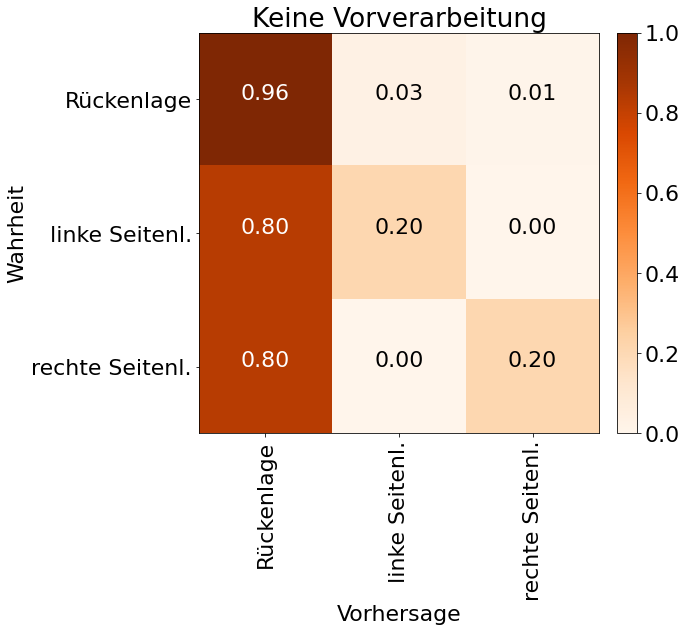

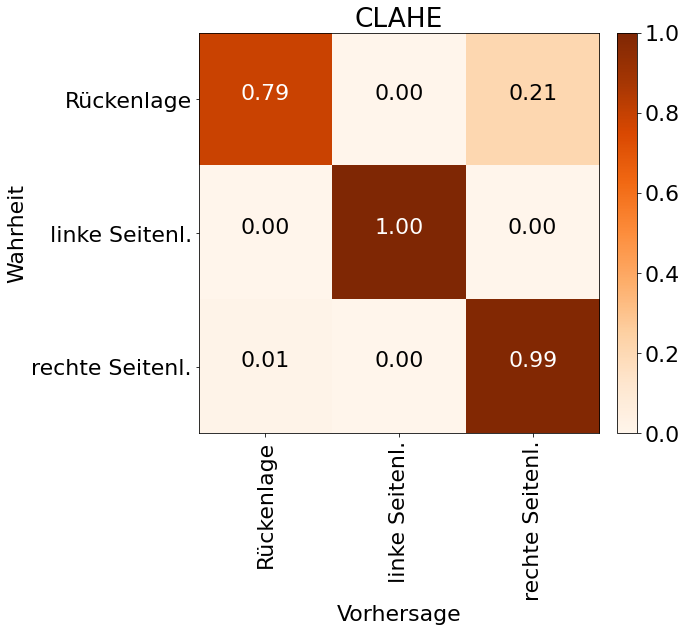

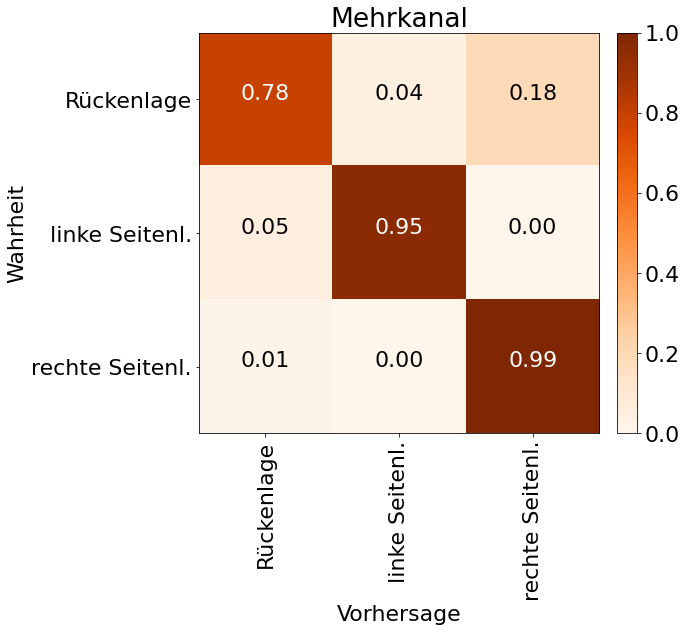

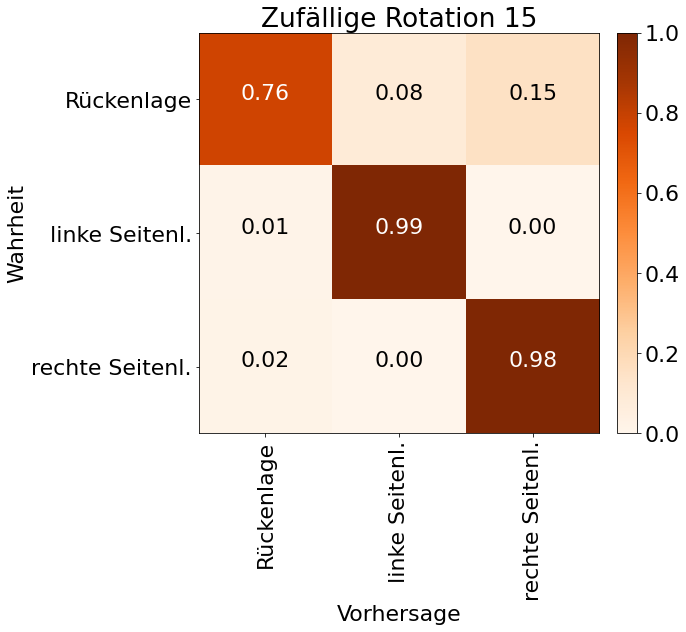

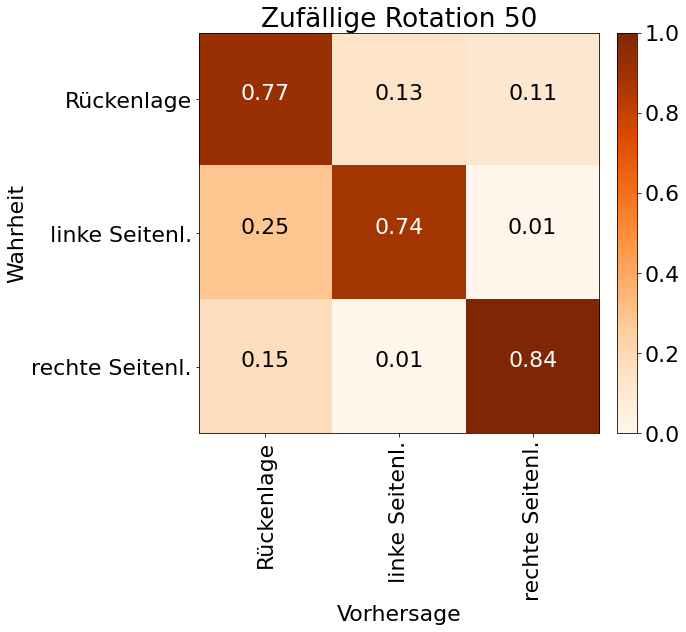

In [7]:
dirs = os.listdir(Path("runs"))
matrices = []
titles = ["Referenzexperiment", "Schwellwertoperation", "Sobel", "Hochpassfilter", "Rauschentfernung", "Dynamisches Schließen", "Zufällige Rotation 30", "Keine Vorverarbeitung", "CLAHE", "Mehrkanal", "Zufällige Rotation 15", "Zufällige Rotation 50"]
for i, run in enumerate(dirs):
    path = Path("runs").joinpath(run).joinpath("confmat.npy")
    conf_mat = np.load(str(path))
    with open(f"runs/{run}/name.txt", "r") as f:
        name = f.read()
    # print(name)
    # print(list(map(lambda n: format(n, '.4f').replace(".", ","), f1_scores_from_conf_mat(conf_mat))))
    # print(format(sum(f1_scores_from_conf_mat(conf_mat))/3, '.4f').replace(".", ","))
    fig = plot_confusion_matrix(conf_mat, title=titles[i], normalize=True)
    fig.set_facecolor("white")
    fig.savefig(f"{titles[i].lower().replace(' ', '-')}.png")
    # data = plt.imread("cf.png")
    # data = torch.from_numpy(data.copy()).permute(2, 0, 1)
    # matrices.append(data)
    # os.remove("cf.png")
# image_grid = torchvision.utils.make_grid(torch.stack(matrices), nrow=4)
# torchvision.utils.save_image(image_grid.float(), "images/confmats.png")